## MVA 2019-20 - TP3

To download this notebook or its pdf version:

http://geometrica.saclay.inria.fr/team/Fred.Chazal/MVA2019.html

Documentation for the latest version of Gudhi: 

http://gudhi.gforge.inria.fr/python/latest/

# Sensor data

Download the data at the following address: http://geometrica.saclay.inria.fr/team/Fred.Chazal/slides/data_acc.dat, save it as a file named [data_acc.dat](http://geometrica.saclay.inria.fr/team/Fred.Chazal/slides/data_acc.dat), and load it using the pickle module:

In [2]:
!wget http://geometrica.saclay.inria.fr/team/Fred.Chazal/slides/data_acc.dat --no-check-certificate

--2019-12-03 11:08:19--  http://geometrica.saclay.inria.fr/team/Fred.Chazal/slides/data_acc.dat
Resolving geometrica.saclay.inria.fr (geometrica.saclay.inria.fr)... 195.83.213.221
Connecting to geometrica.saclay.inria.fr (geometrica.saclay.inria.fr)|195.83.213.221|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://geometrica.saclay.inria.fr/team/Fred.Chazal/slides/data_acc.dat [following]
--2019-12-03 11:08:20--  https://geometrica.saclay.inria.fr/team/Fred.Chazal/slides/data_acc.dat
Connecting to geometrica.saclay.inria.fr (geometrica.saclay.inria.fr)|195.83.213.221|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 4266970 (4,1M) [text/plain]
Saving to: ‘data_acc.dat’

data_acc.dat        100%[===================>]   4,07M   703KB/s    in 9,0s    

2019-12-03 11:08:30 (463 KB/s) - ‘data_acc.dat’ saved [4266970/4266970]



In [1]:
import numpy as np
import pickle as pickle
import gudhi as gd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

f = open("data_acc.dat","rb")
data = pickle.load(f,encoding="latin1")
f.close()
data_A = data[0]
data_B = data[1]
data_C = data[2]
label = data[3]

%matplotlib inline

In [2]:
plt.style.use("seaborn")
plt.rcParams['figure.dpi'] = 100

In [3]:
# Import plotly for interactive 3D plotting
import plotly.graph_objects as go
import plotly.express as px

The walk of 3 persons A, B and C has been recorded using the accelerometer sensor of a smartphone in their pocket, giving rise to 3 multivariate time series in $\mathbb{R}^3$: each time series represents the 3 coordinates of the acceleration of the corresponding person in a coordinate system attached to the sensor (take care that, as the smartphone was carried in a possibly different position for each person, these time series cannot be compared coordinates by coordinates). Using a sliding window, each series has been split in a list of 100 time series made of 200 consecutive points, that are now stored in data_A, data_B and data_C.

* Plot a few of the time series to get an idea of the corresponding point clouds in $\mathbb{R}^3$. For example:

In [4]:
idx = 10
data_A_sample = data_A[idx]

data_A_sample.shape

(200, 3)

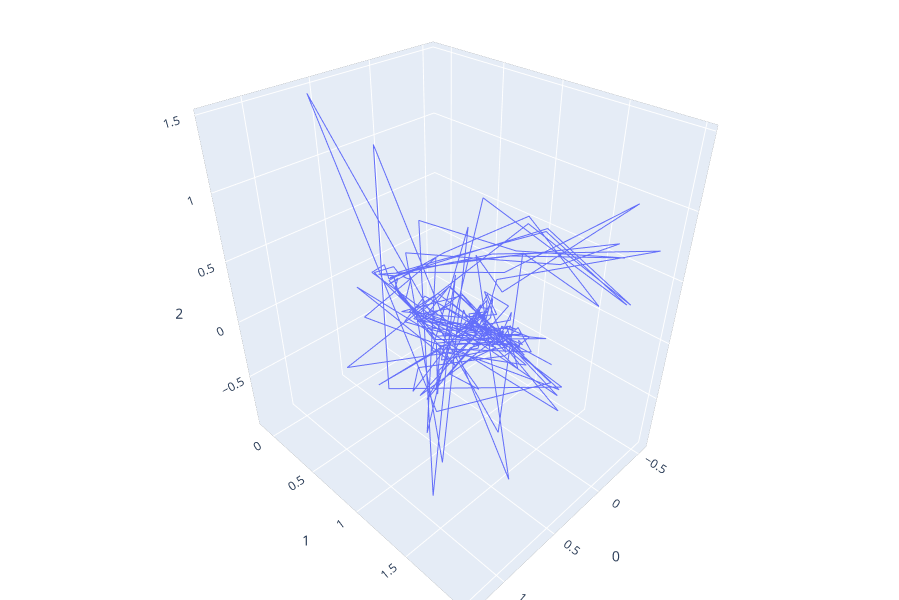

In [6]:
fig = px.line_3d(data_A_sample, x=0, y=1, z=2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

In [65]:
# plt.gca(projection='3d')
# plt.plot(data_A_sample [:,0],data_A_sample [:,1],data_A_sample [:,2])

In [7]:
# define the RipsComplex
rips = gd.RipsComplex(points=data_A_sample)

rips_tree = rips.create_simplex_tree(max_dimension=2)  # max_dimension is important

print("Vietoris-Rips complex in dimension %d, has\n%d vertices, %d simplices" % (rips_tree.dimension(),rips_tree.num_vertices(),rips_tree.num_simplices()))

rips_pers = rips_tree.persistence()  # get persistence of Rips

Vietoris-Rips complex in dimension 2, has
200 vertices, 1333500 simplices


Deprecated parameter. It has been replaced by max_intervals


<module 'matplotlib.pyplot' from '/home/manifold/miniconda3/envs/tda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

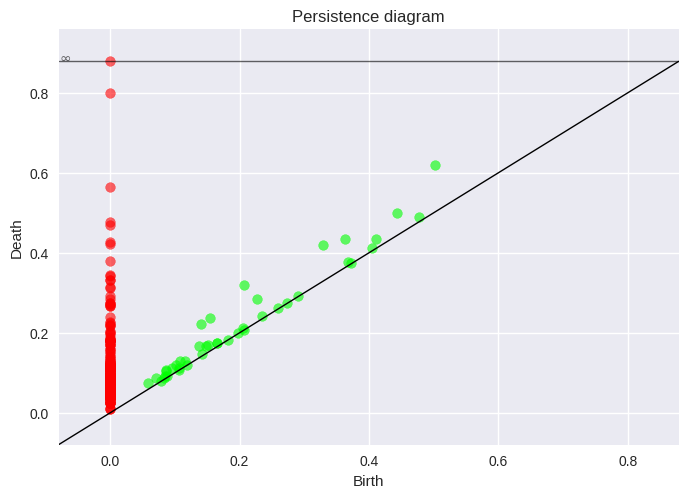

In [8]:
gd.plot_persistence_diagram(rips_pers)

In [9]:
alpha_cplx: gd.AlphaComplex = gd.AlphaComplex(points=data_A_sample)
alpha_tree = alpha_cplx.create_simplex_tree()

print("Alpha complex in dimension %d -- has %d vertices and %d simplices" 
      % (alpha_tree.dimension(), alpha_tree.num_vertices(), alpha_tree.num_simplices()))

alpha_pers = alpha_tree.persistence()

Alpha complex in dimension 3 -- has 200 vertices and 5043 simplices


Deprecated parameter. It has been replaced by max_intervals


<module 'matplotlib.pyplot' from '/home/manifold/miniconda3/envs/tda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

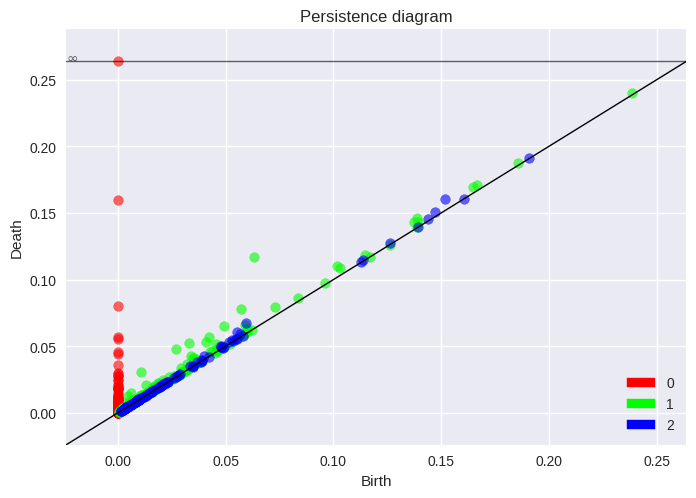

In [10]:
gd.plot_persistence_diagram(alpha_pers, legend=True)

* Compute and plot the persistence diagrams of the Vietoris-Rips and the alpha-complex filtrations, for a few examples of the time series.

In [16]:
subset_ts = [0, 10, 20, 30, 35, 40, 50, 55, 60, 70, 80, 90]

In [17]:
sub_datas = [
    [data_A[idx] for idx in subset_ts],
    [data_B[idx] for idx in subset_ts],
    [data_C[idx] for idx in subset_ts],
]

In [18]:
idx_to_class = np.zeros((3*len(subset_ts),))
idx_to_class[len(subset_ts):2*len(subset_ts)] = 1
idx_to_class[2*len(subset_ts):] = 2
idx_to_class

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2.])

In [19]:
def compute_persistence_rips_ts(timeseries: np.ndarray):
    rips: gd.RipsComplex = gd.RipsComplex(points=timeseries)
    tree: gd.SimplexTree = rips.create_simplex_tree(max_dimension=2)
    pers = tree.persistence()
    
    return pers, (tree.persistence_intervals_in_dimension(0), tree.persistence_intervals_in_dimension(1))
    
    
def compute_persistence_alpha_ts(timeseries: np.ndarray):
    alpha: gd.AlphaComplex = gd.AlphaComplex(points=timeseries)
    tree: gd.SimplexTree = alpha.create_simplex_tree()
    pers = tree.persistence()
    
    return pers, (tree.persistence_intervals_in_dimension(0), tree.persistence_intervals_in_dimension(1))

In [20]:
rips_diagrams = []
rips_diagrams_0 = []
rips_diagrams_1 = []

alph_diagrams = []
alph_diagrams_0 = []
alph_diagrams_1 = []


cls_list = ['A', 'B', 'C']

for i, clx_d in enumerate(sub_datas):
    print("class %s" % cls_list[i])
    for k, ts in enumerate(clx_d):
        print("Sample #%d" % (k+1), end='\r')
        gdpers, rips_pers = compute_persistence_rips_ts(ts)
        rips_diagrams.append(gdpers)
        rips_diagrams_0.append(rips_pers[0])  # in dim 0
        rips_diagrams_1.append(rips_pers[1])  # in dim 1
        
        gdpers, alph_pers = compute_persistence_alpha_ts(ts)
        alph_diagrams.append(gdpers)
        alph_diagrams_0.append(alph_pers[0])  # in dim 0
        alph_diagrams_1.append(alph_pers[1])  # in dim 1
    print()

class A
Sample #12
class B
Sample #12
class C
Sample #12


* Compute the 0-dimensional and 1-dimensional persistence diagrams (α-shape or Rips-Vietoris filtration) of all the time series. Compute the matrix of pairwise distances between the diagrams (as this may take a while, you can just select a subset of all the diagrams where each of the 3 classes A, B and C are represented). Visualize the pairwise distances via Multidimensional Scaling (use a different color for each class). You can use sklearn for that (B1 denotes the matrix of pairewise distances):

In [21]:
import itertools

from typing import List

In [22]:
def compute_distance_matrix(diag_list: List[np.ndarray]):
    n = len(diag_list)  # num of diagrams
    dist_matrix = np.zeros((n, n))
    for (i,j) in itertools.combinations(range(n), 2):
        dist_matrix[i, j] = dist_matrix[j, i] = gd.bottleneck_distance(diag_list[i], diag_list[j])
    return dist_matrix

In [29]:
def display_dist_matrix(dist_matrix: np.ndarray, title: str = None):
    fig, ax = plt.subplots()
    im = ax.imshow(dist_matrix)

    # We want to show all ticks...
    ax.set_xticks(np.arange(0, dist_matrix.shape[0], 2))
    ax.set_yticks(np.arange(0, dist_matrix.shape[1], 2))

    ax.grid(False)
    fig.colorbar(im);

In [26]:
dist_matrix_rips_0 = compute_distance_matrix(rips_diagrams_0)

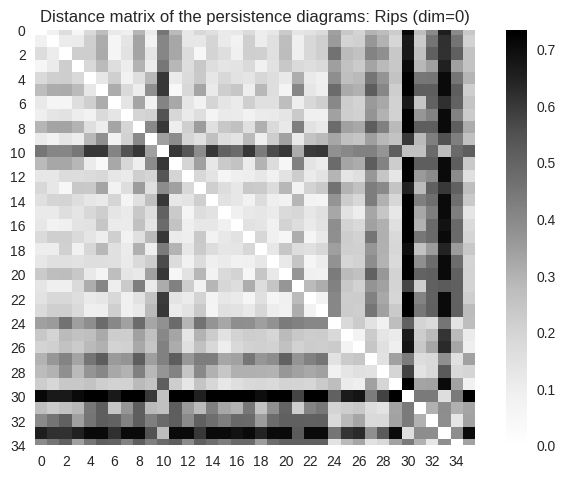

In [30]:
display_dist_matrix(dist_matrix_rips_0)
plt.title("Distance matrix of the persistence diagrams: Rips (dim=0)");

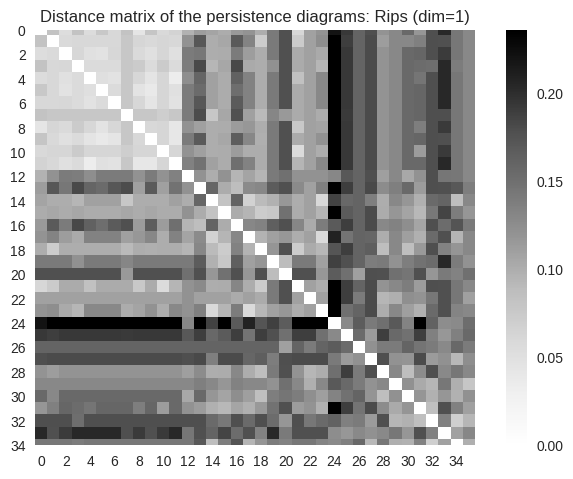

In [31]:
dist_matrix_rips_1 = compute_distance_matrix(rips_diagrams_1)

display_dist_matrix(dist_matrix_rips_1)
plt.title("Distance matrix of the persistence diagrams: Rips (dim=1)");

## Matrix plots for Alpha complex

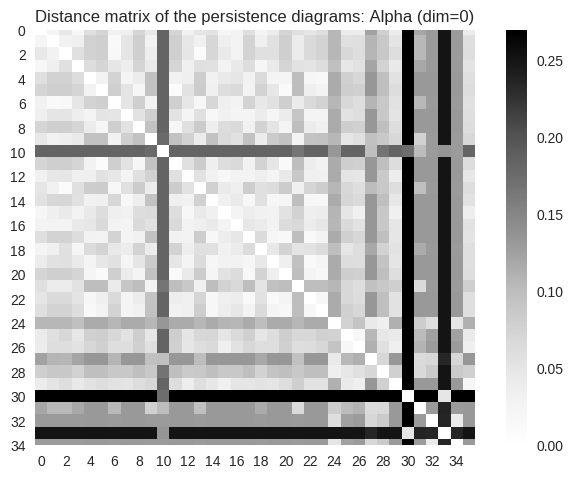

In [32]:
dist_matrix_alpha_0 = compute_distance_matrix(alph_diagrams_0)

display_dist_matrix(dist_matrix_alpha_0)
plt.title("Distance matrix of the persistence diagrams: Alpha (dim=0)");

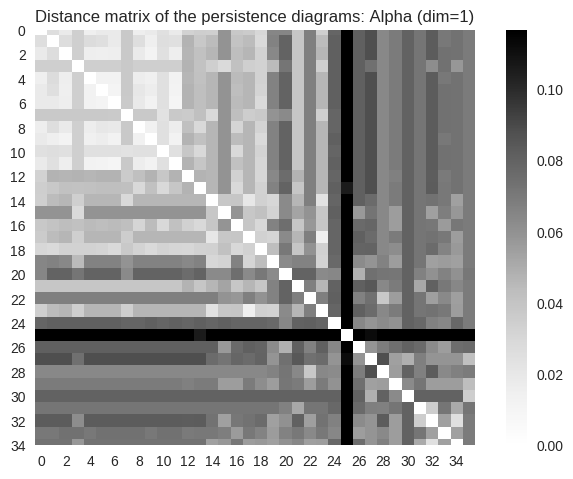

In [33]:
dist_matrix_alpha_1 = compute_distance_matrix(alph_diagrams_1)

display_dist_matrix(dist_matrix_alpha_1)
plt.title("Distance matrix of the persistence diagrams: Alpha (dim=1)");

## Embedded point cloud

Using MDS.

In [34]:
from matplotlib import cm

In [44]:
# B is the pairwise distance matrix between 0 or 1-dim dgms
#label_color contains the colors corresponding to the class of each dgm
mds = manifold.MDS(n_components=3, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
pos1 = mds.fit(dist_matrix_rips_0).embedding_

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')


#for cls_idx in [0, 1, 2]:
#    points_ = pos1[idx_to_class == cls_idx]
#    ax.scatter(*points_.T, marker = 'o', label=cls_list[cls_idx]);
#ax.legend()

In [49]:
idx_to_class_lbl = list(map(lambda t: cls_list[int(t)], idx_to_class))

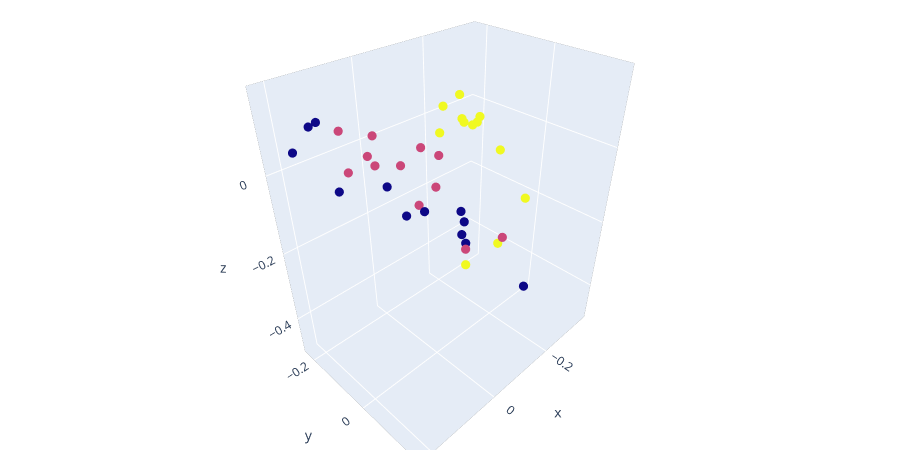

In [51]:
fig: go.Figure = go.Figure()
fig.add_scatter3d(x=pos1[:, 0], y=pos1[:, 1], z=pos1[:, 2],
                  hovertext=idx_to_class_lbl,
                  mode='markers', marker=dict(size=3.,
                                              color=idx_to_class))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

* Use the function below to embed the data in dimension 3×3 = 9 with a delay equal to 2 (time-delay embedding) and do the same experiments as previously, using the Vietoris-Rips filtration this time.

In [52]:
def sliding_window_data(x,edim,delay=1):
    """time delay embedding of a d-dim times series into R^{d*edim}
    the time series is assumed to be periodic
    parameters:
        + x: a list of d lists of same length L or a dxL numpy array
        + edim: the number of points taken to build the embedding in R^{d*edim}
        + delay: embeeding given by (x[i],x[i+delay],...,x[i + (edim-1)*delay])
            Default value for delay is 1
    """
    ts = np.asarray(x)
    if len(np.shape(ts)) == 1:
        ts = np.reshape(ts,(1,ts.shape[0]))
    ts_d = ts.shape[0]
    ts_length = ts.shape[1]
    #output = zeros((edim*ts_d,nb_pt))
    output = ts
    for i in range(edim-1):
        output = np.concatenate((output,np.roll(ts,-(i+1)*delay,axis=1)),axis=0)
    return output

# Persistence landscapes

Landscape construction is currently only available in the C++ version of Gudhi. Here is a simple python implementation you can use for this class.

In [53]:
def landscapes_approx(diag,p_dim,x_min,x_max,nb_nodes,nb_ld):
    """Compute a dicretization of the first nb_ld landscape of a 
    p_dim-dimensional persistence diagram on a regular grid on the 
    interval [x_min,x_max]. The output is a nb_ld x nb_nodes numpy
    array
    + diag: a persistence diagram (in the Gudhi format)
    + p_dim: the dimension in homology to consider
    """
    landscape = np.zeros((nb_ld,nb_nodes))
    diag_dim = []
    for pair in diag: #get persistence points for homology in dimension dim
        if (pair[0] == p_dim):
            diag_dim.append(pair[1])

    step = (x_max - x_min) / (nb_nodes - 1)
    #Warning: naive and not the most efficient way to proceed!!!!!
    for i in range(nb_nodes):
        x = x_min + i * step
        t = x / np.sqrt(2)
        event_list = []
        for pair in diag_dim:
            b = pair[0]
            d = pair[1]
            if b <= t <= d:
                if t >= (d+b)/2:
                    event_list.append((d-t)*np.sqrt(2))
                else:
                    event_list.append((t-b)*np.sqrt(2))
        event_list.sort(reverse=True)
        event_list = np.asarray(event_list)
        for j in range(nb_ld):
            if(j<len(event_list)):
                landscape[j,i]=event_list[j]

    return landscape


* Test the function on a few examples of diagrams and plot the resulting landscapes.

In [54]:
# Example of parameters, you don't have to use those
nb_ld = 5 # number of Landscapes 
nb_nodes = 500
length_max = 1.0

In [63]:
idx = 0

lscape_range = np.linspace(0, 1.2, nb_nodes)

lscapes_ = [
    landscapes_approx(rips_diagrams[idx],p, 0., 1.2, nb_nodes, nb_ld)
    for p in [0, 1]
]

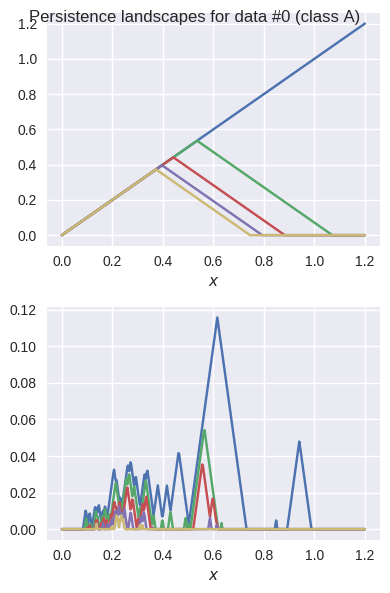

In [64]:
fig, (ax0, ax1) = plt.subplots(2, figsize=(4,6))

ax0.plot(lscape_range, lscapes_[0].T);
ax0.set_xlabel("$x$");

ax1.plot(lscape_range, lscapes_[1].T);
ax1.set_xlabel("$x$");

fig.suptitle("Persistence landscapes for data #%d (class %s)" % (idx, idx_to_class_lbl[idx]))
fig.tight_layout();

In [65]:
idx = 8

lscape_range = np.linspace(0, 1.2, nb_nodes)

lscapes_ = [
    landscapes_approx(rips_diagrams[idx],p, 0., 1.2, nb_nodes, nb_ld)
    for p in [0, 1]
]

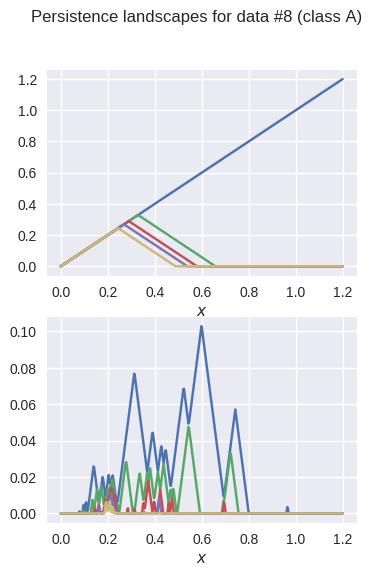

In [68]:
fig, (ax0, ax1) = plt.subplots(2, figsize=(4,6))

ax0.plot(lscape_range, lscapes_[0].T);
ax0.set_xlabel("$x$");

ax1.plot(lscape_range, lscapes_[1].T);
ax1.set_xlabel("$x$");

fig.suptitle("Persistence landscapes for data #%d (class %s)" % (idx, idx_to_class_lbl[idx]));
#fig.tight_layout();

* Compute and store the persistence landscapes of the accelerometer time series. Use the obtained landscapes to experiment with supervised and non supervised classification on this data.

### Classification with landscapes as features

In [69]:
rips_landscapes_ = {
    p:
    np.dstack([
        landscapes_approx(rips_diagrams[idx], p, 0., 1.2, nb_nodes, nb_ld)
        for idx in range(len(rips_diagrams))
    ])
    for p in [0, 1]
}

In [73]:
# Transpose for features
rips_landscapes_0 = np.transpose(rips_landscapes_[0])
print(rips_landscapes_0.shape)

# Transpose for features
rips_landscapes_1 = np.transpose(rips_landscapes_[1])
print(rips_landscapes_1.shape)

(36, 500, 5)
(36, 500, 5)


### Linear SVM

In [124]:
X0_train, X0_test, X1_train, X1_test, lbl_train, lbl_test  = train_test_split(
    rips_landscapes_0, rips_landscapes_1, idx_to_class_lbl, test_size=0.5)

In [125]:
X_train = np.dstack((X0_train, X1_train))

X_train = X_train.reshape(X_train.shape[0], -1)
X_train.shape

(18, 5000)

In [126]:
X_test = np.dstack((X0_test, X1_test))
X_test = X_test.reshape(X_test.shape[0], -1)
X_test.shape

(18, 5000)

In [127]:
from sklearn import ensemble

In [128]:
model = ensemble.RandomForestClassifier()

In [129]:
model.fit(X_train, lbl_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
model.score(X_test, lbl_test)

1.0

# Classification of orbits of dynamical systems

The goal of this exercise is to classify sequences of points (orbits) generated by different dynamical systems. Given some initial position $(x_0, y_0) \in [0,1]^2$ and a parameter $r > 0$, we generate a 2D point cloud $(x_n,y_n)_{n = 1, \dots, N}$ following:

\begin{align}
	\begin{cases}
		x_{n+1} = x_n + r y_n (1 - y_n) 		&\text{ mod } 1 \\
		y_{n+1} = y_n + r x_{n+1} (1 - x_{n+1}) &\text{ mod } 1		
	\end{cases}
\end{align}

The orbits of this dynamical system heavily depend on parameter $r$. More precisely, for some values of $r$, voids might form in these orbits.

1. With random initialisation, five different parameters $r \in \{ 2.5, 3.5, 4, 4.1, 4.3 \}$, a thousand iterations per trajectory ($N = 1000$), generate a thousand orbits per parameter to obtain a datasets of five thousand orbits. 
Each orbit if labeled by its associated parameter $r$. 
Plot a few orbits to get an idea of how they look like.

2. Propose one or more methods to classify these orbits and evaluate them using a 10-fold cross validation. Compare the results of the different methods. At least one of the proposed method should use TDA features (persistence diagrams). 
You can also compare your results to the ones of https://arxiv.org/abs/1904.09378 and https://arxiv.org/abs/1909.13472

## Dynamical system

In [187]:
def run_simulation(x0, y0, r, num_iters, num_traj):
    XY = np.empty((num_traj, num_iters, 2))
    XY[:, 0] = x0, y0
    for i in range(1, num_iters):
        x = XY[:, i-1, 0]
        y = XY[:, i-1, 1]
        x = XY[:, i, 0] = np.mod(x + r * y * (1 - y), 1.)
        XY[:, i, 1] = np.mod(y + r * x * (1 - x), 1.)
    return XY

In [200]:
r_values_ = [2.5, 3.5, 4, 4.1, 4.3]
x0 = 0.1
y0 = 0.4

In [201]:
num_iters = 1000
num_traj = 1000

## Generate a trajectory for each value of r
trajectories_ = [
    list(run_simulation(x0, y0, r, num_iters, num_traj))
    for r in r_values_
]

In [223]:
# Take 3 trajectories per r value -- for plotting
traj_subsample = [(r,t) for (r, r_trajs) in zip(r_values_, trajectories_) for t in r_trajs[:3]]

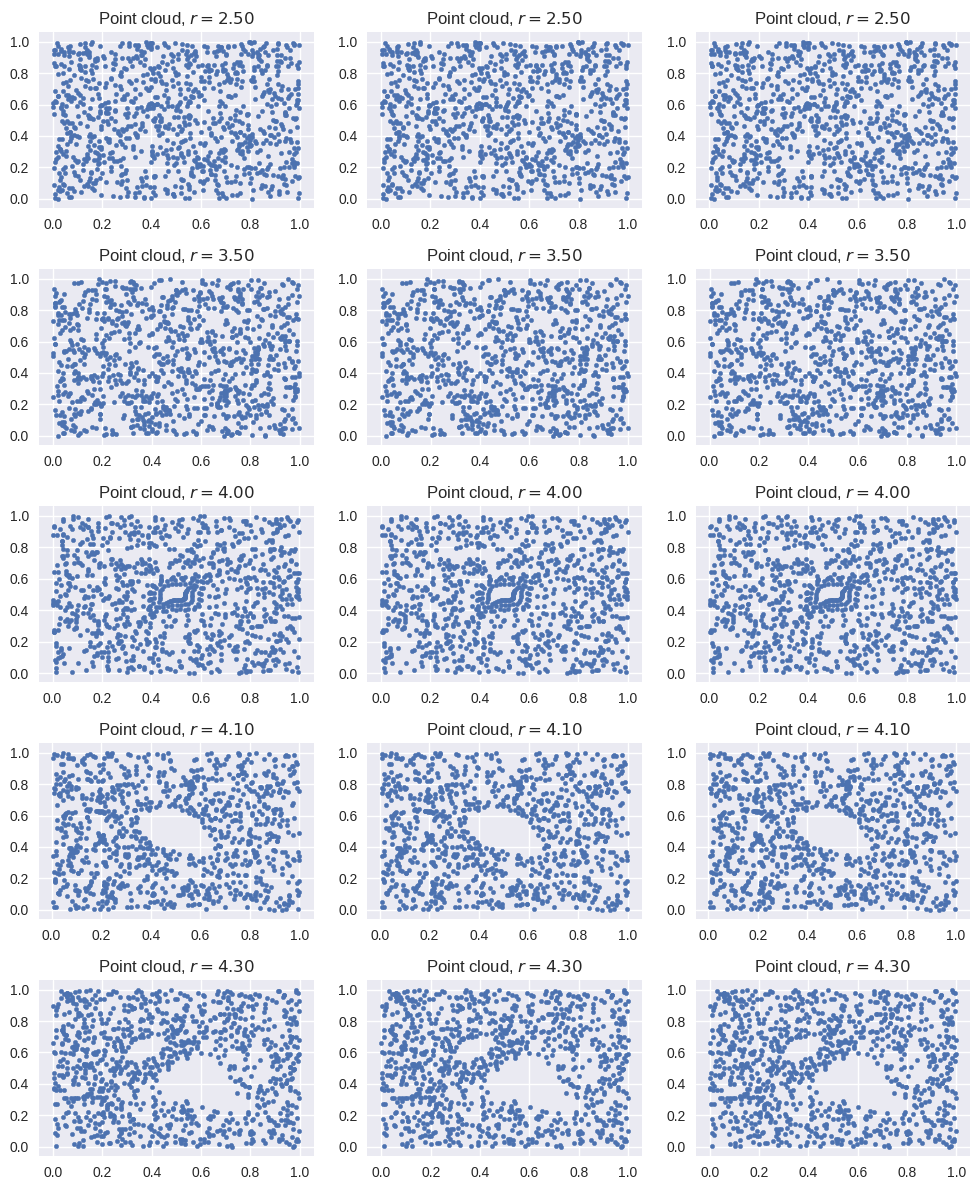

In [231]:
num_plots = len(traj_subsample)

ncols = 3

fig, axes = plt.subplots(
    num_plots // ncols, ncols,
    figsize=(10, 12))
axes = axes.flatten()

for i, (ax, (r, traj)) in enumerate(zip(axes, traj_subsample)):
    ax.scatter(*traj.T, s=10)
    ax.set_title("Point cloud, $r=%.2f$" % r)

fig.tight_layout();

# Bootstrap and confidence bands for lanscapes

The goal of this exercise is to implement the bootstrap algorithm below from [ F. Chazal, B.T. Fasy, F. Lecci, A. Rinaldo, L. Wasserman. *Stochastic Convergence of Persistence Landscapes and Silhouettes.*  in Journal of Computational Geometry, 6(2), 140-161, 2015] to compute confidence bands for landscapes. As an example compute confidence bands for the expected landscapes for each of the 3 classes in the accelerometer data set.

## The multiplier bootstrap algorithm.
*Input:* landscapes $\lambda_1,\ldots,\lambda_n$; confidence level $1-\alpha$; number of bootstrap samples $B$  
*Output:* confidence functions $\ell_n, u_n \colon \mathbb{R} \to \mathbb{R}$
1. Compute the average $\overline{\lambda}_n(t) = \frac{1}{n}\sum_{i=1}^n {\lambda}_i(t)$, for all $t$
1. For $j=1$ to $B$:
1. &nbsp; &nbsp; Generate $\xi_1,\ldots, \xi_n \sim N(0,1)$
1. &nbsp; &nbsp; Set  $\tilde\theta_j = \sup_t n^{-1/2} |\sum_{i=1}^n \xi_i\ ({\lambda}_i(t) - \overline{\lambda}_n(t))|$
1. End for
1. Define $\tilde Z(\alpha) = \inf\bigl\{ z:\ \frac{1}{B}\sum_{j=1}^B I( \tilde\theta_j > z) \leq \alpha\bigr\}$
1. Set $\ell_n(t) = \overline{\lambda}_n(t) - \frac{\tilde Z(\alpha)}{\sqrt{n}}$ and $u_n(t) = \overline{\lambda}_n(t) + \frac{\tilde Z(\alpha)}{\sqrt{n}}$
1. Return $\ell_n(t), u_n(t)$